In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from mutagenicity_dataset import *
# from feature_engineering.node_features import *

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
### LOAD DATASET ###
data_path = './data'
transform = get_combined_mapping_transform()
dataset = TUDataset(root=data_path, name='Mutagenicity', transform=transform)

In [4]:
### CONVERT TO NETWORKX ###
dataset_nx = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atom'])
    dataset_nx.append(G)
dataset_nx = np.array(dataset_nx, dtype=nx.classes.graph.Graph)

100%|██████████| 4337/4337 [00:01<00:00, 3641.25it/s]


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw


def nx_to_rdkit(G):
    """
    Convert a NetworkX graph G to an RDKit molecule.
    
    Assumes:
      - Each node has an attribute "atom" that contains the element symbol (e.g., "C", "O", etc.)
      - Each edge has an attribute "bond" that is an integer (1, 2, or 3) representing the bond order.
    """
    # Create an editable RDKit molecule
    rwmol = Chem.RWMol()
    
    # Map NetworkX nodes to RDKit atom indices
    node_to_idx = {}
    for node, data in G.nodes(data=True):
        atom_symbol = data.get('atom')
        if atom_symbol is None:
            raise ValueError(f'Node {node} does not have an \'atom\' attribute')
        atom = Chem.Atom(atom_symbol)
        idx = rwmol.AddAtom(atom)
        node_to_idx[node] = idx

    # Add bonds between atoms
    for u, v, data in G.edges(data=True):
        bond_order = data.get('bonds')
        if bond_order is None:
            raise ValueError(f'Edge ({u}, {v}) does not have a \'bonds\' attribute')
        if bond_order == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
        elif bond_order == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
        elif bond_order == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
        else:
            raise ValueError(f'Unsupported bond order {bond_order} on edge ({u}, {v})')
        
        # Add the bond using the mapped indices
        rwmol.AddBond(node_to_idx[u], node_to_idx[v], bond_type)

    # Check if the atom is nitrogen with 4 bonds, and if it is, give it formal charge +1
    for atom in rwmol.GetAtoms():
        if atom.GetSymbol() == 'N':
            total_bonds = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if total_bonds == 4:  # Overbonded N atom
                atom.SetFormalCharge(1)
    
    # Check if the atom is oxygen with 3 bonds, and if it is, give it formal charge +1
    for atom in rwmol.GetAtoms():
        if atom.GetSymbol() == 'O':
            total_bonds = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if total_bonds == 3:  # Overbonded oxygen
                atom.SetFormalCharge(1)


    # Convert to a standard RDKit Mol object
    mol = rwmol.GetMol()
    
    # Sanitize the molecule (this checks valences, computes aromaticity, etc.)
    Chem.SanitizeMol(mol)
    return mol

If we sanitize the mol, data at idx 600 gives error (4 bonds from N when only 3 are permitted)

In [6]:
#problematic

[H]c1nc(N([H])[H])sc1[H]


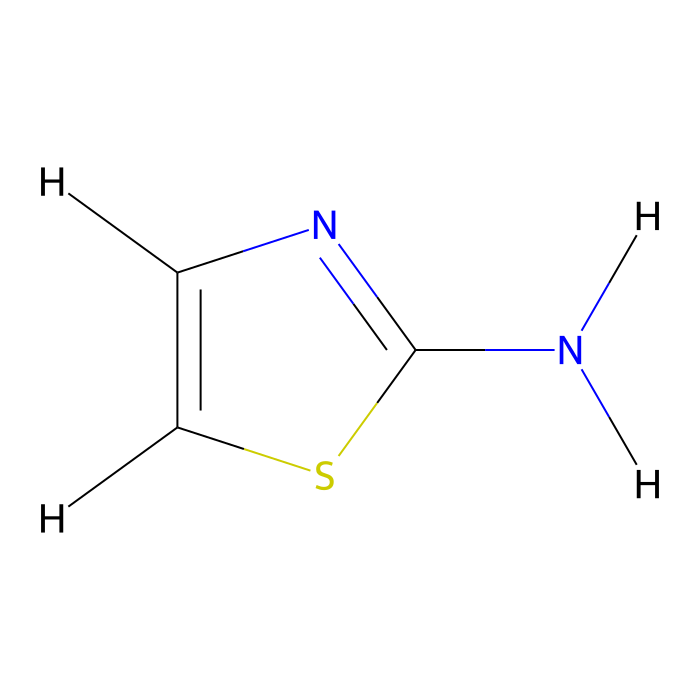

In [7]:
G = dataset_nx[1006]
mol = nx_to_rdkit(G)
print(Chem.MolToSmiles(mol))
img = Draw.MolToImage(mol, size=(700,700))
img

In [8]:
for atom in mol.GetAtoms():
    if atom.GetSymbol() == 'O' and atom.GetFormalCharge() == 1:
        print(f"Quaternary ammonium detected on atom {atom.GetIdx()}.")

In [9]:
# print(G.edges(data=True))
# print(G.nodes(data=True))
# nx.draw(G, with_labels=True)

These N atoms with 4 bonds could be N atoms with 3 bonds but that have positive formal charge of 1. Make note of this. I wasn't able to find information about this in the paper that describes the dataset though.

Let's try checking for functional groups now:

In [10]:
from rdkit.Chem import Fragments

countUnique=True
fr_NH0: 1
fr_benzene: 2
fr_bicyclic: 3


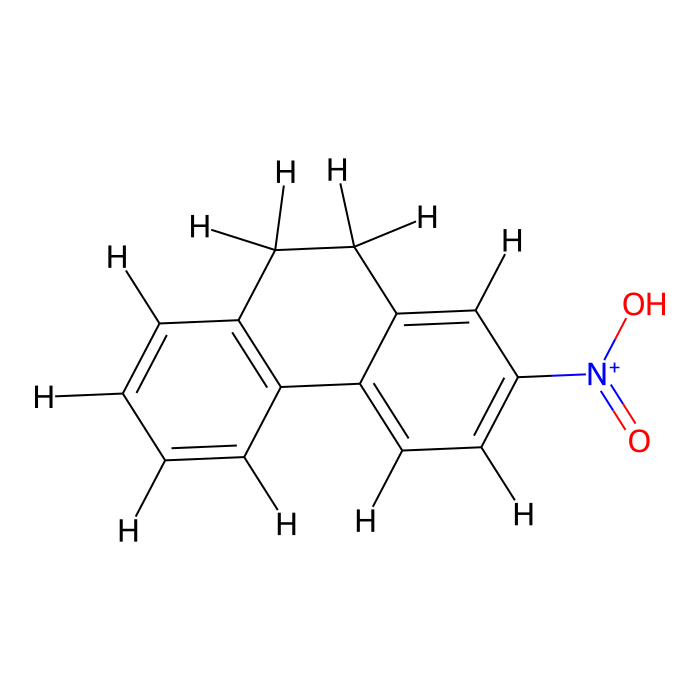

In [11]:
def apply_all_fragments_dynamic(mol):
    # Discover all fragment-checking functions in the module (Should be 85)
    fragment_funcs = [func for func in dir(Fragments) if func.startswith('fr_') and callable(getattr(Fragments, func))]

    results = {}
    
    # Apply each function to the molecule
    for func_name in fragment_funcs:
        func = getattr(Fragments, func_name)
        try:
            result = func(mol)  # Counts occurences of func group, not including spatial permutations
            results[func_name] = result
        except Exception as e:
            results[func_name] = f"Error: {str(e)}"
    
    return results

# Example: Applying to a simple molecule (ethanol)
G = dataset_nx[1007]
mol = nx_to_rdkit(G)
results = apply_all_fragments_dynamic(mol)
# results_nonuniq = apply_all_fragments_dynamic(mol, count_unique=False)

# Display results
print('countUnique=True')
for fragment, count in results.items():
    if count > 0:
        print(f"{fragment}: {count}")

# print('\ncountUnique=False')
# for fragment, count in results_nonuniq.items():
#     if count > 0:
#         print(f"{fragment}: {count}")

img = Draw.MolToImage(mol, size=(700, 700))
img

Testing difference between countUnique param for Chem.Fragments funcs.

1 12


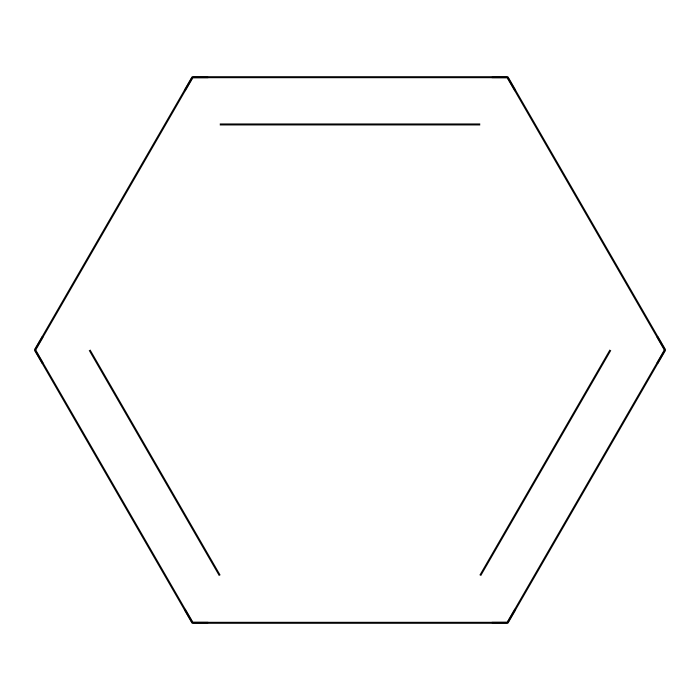

In [12]:
benzene = Chem.MolFromSmiles("c1ccccc1")
naphthalene = Chem.MolFromSmiles("c1ccc2ccccc2c1")
mol = benzene
benzene_unique = Fragments.fr_benzene(mol, countUnique=True)
benzene_count = Fragments.fr_benzene(mol, countUnique=False)

print(benzene_unique, benzene_count)
Draw.MolToImage(mol, size=(700, 700))

Now calculate for the entire dataset.

In [13]:
datasubset_nx = dataset_nx
frag_counts = []
for G in tqdm(datasubset_nx):
    mol = nx_to_rdkit(G)
    frag_counts.append(apply_all_fragments_dynamic(mol))

100%|██████████| 4337/4337 [00:02<00:00, 1979.24it/s]


In [14]:
len(frag_counts)
frag_counts

[{'fr_Al_COO': 0,
  'fr_Al_OH': 0,
  'fr_Al_OH_noTert': 0,
  'fr_ArN': 0,
  'fr_Ar_COO': 0,
  'fr_Ar_N': 0,
  'fr_Ar_NH': 0,
  'fr_Ar_OH': 0,
  'fr_COO': 0,
  'fr_COO2': 0,
  'fr_C_O': 2,
  'fr_C_O_noCOO': 2,
  'fr_C_S': 0,
  'fr_HOCCN': 0,
  'fr_Imine': 0,
  'fr_NH0': 0,
  'fr_NH1': 0,
  'fr_NH2': 0,
  'fr_N_O': 0,
  'fr_Ndealkylation1': 0,
  'fr_Ndealkylation2': 0,
  'fr_Nhpyrrole': 0,
  'fr_SH': 0,
  'fr_aldehyde': 0,
  'fr_alkyl_carbamate': 0,
  'fr_alkyl_halide': 0,
  'fr_allylic_oxid': 0,
  'fr_amide': 0,
  'fr_amidine': 0,
  'fr_aniline': 0,
  'fr_aryl_methyl': 0,
  'fr_azide': 0,
  'fr_azo': 0,
  'fr_barbitur': 0,
  'fr_benzene': 1,
  'fr_benzodiazepine': 0,
  'fr_bicyclic': 0,
  'fr_diazo': 0,
  'fr_dihydropyridine': 0,
  'fr_epoxide': 0,
  'fr_ester': 0,
  'fr_ether': 0,
  'fr_furan': 0,
  'fr_guanido': 0,
  'fr_halogen': 2,
  'fr_hdrzine': 0,
  'fr_hdrzone': 0,
  'fr_imidazole': 0,
  'fr_imide': 0,
  'fr_isocyan': 0,
  'fr_isothiocyan': 0,
  'fr_ketone': 0,
  'fr_ketone_Topl

Seems to work super fast. Let's see what the frag counts look like for our dataset, and get an idea of how to define our queries (i.e. for what counts should we create queries?).

In [15]:
# Initialize dict
frag_names = frag_counts[0].keys()
frag_dict = {}
frag_total = {}
for name in frag_names:
    frag_dict[name] = []
    frag_total[name] = 0

# Get counts
for count_dict in frag_counts:
    for name in frag_names:
        frag_dict[name] = frag_dict[name] + [count_dict[name]]
        frag_total[name] = frag_total[name] + count_dict[name]

In [16]:
print(frag_dict)

{'fr_Al_COO': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
frag_total

{'fr_Al_COO': 359,
 'fr_Al_OH': 1106,
 'fr_Al_OH_noTert': 148,
 'fr_ArN': 698,
 'fr_Ar_COO': 100,
 'fr_Ar_N': 1542,
 'fr_Ar_NH': 228,
 'fr_Ar_OH': 732,
 'fr_COO': 459,
 'fr_COO2': 472,
 'fr_C_O': 2538,
 'fr_C_O_noCOO': 2080,
 'fr_C_S': 26,
 'fr_HOCCN': 23,
 'fr_Imine': 40,
 'fr_NH0': 3692,
 'fr_NH1': 1244,
 'fr_NH2': 999,
 'fr_N_O': 66,
 'fr_Ndealkylation1': 149,
 'fr_Ndealkylation2': 37,
 'fr_Nhpyrrole': 228,
 'fr_SH': 30,
 'fr_aldehyde': 116,
 'fr_alkyl_carbamate': 7,
 'fr_alkyl_halide': 756,
 'fr_allylic_oxid': 864,
 'fr_amide': 853,
 'fr_amidine': 23,
 'fr_aniline': 1394,
 'fr_aryl_methyl': 471,
 'fr_azide': 0,
 'fr_azo': 149,
 'fr_barbitur': 2,
 'fr_benzene': 5461,
 'fr_benzodiazepine': 5,
 'fr_bicyclic': 4424,
 'fr_diazo': 3,
 'fr_dihydropyridine': 4,
 'fr_epoxide': 216,
 'fr_ester': 533,
 'fr_ether': 1992,
 'fr_furan': 112,
 'fr_guanido': 19,
 'fr_halogen': 1874,
 'fr_hdrzine': 63,
 'fr_hdrzone': 22,
 'fr_imidazole': 181,
 'fr_imide': 47,
 'fr_isocyan': 8,
 'fr_isothiocyan': 6,


In [18]:
# For each fragment, get the unique number of occurences of that fragment in the dataset
unique_counts_dict = {}
for key, val in frag_dict.items():
    unique_counts_dict[key] = list(set(val))  # Get unique by converting to set then back to list
print(len(unique_counts_dict))
unique_counts_dict

85


{'fr_Al_COO': [0, 1, 2, 3, 4],
 'fr_Al_OH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14],
 'fr_Al_OH_noTert': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'fr_ArN': [0, 1, 2, 3, 4, 5],
 'fr_Ar_COO': [0, 1, 2],
 'fr_Ar_N': [0, 1, 2, 3, 4, 5, 6],
 'fr_Ar_NH': [0, 1, 2, 3],
 'fr_Ar_OH': [0, 1, 2, 3, 4, 5, 6],
 'fr_COO': [0, 1, 2, 3, 4],
 'fr_COO2': [0, 1, 2, 3, 4],
 'fr_C_O': [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 14],
 'fr_C_O_noCOO': [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13],
 'fr_C_S': [0, 1, 2],
 'fr_HOCCN': [0, 1, 2, 3],
 'fr_Imine': [0, 1, 2],
 'fr_NH0': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'fr_NH1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15],
 'fr_NH2': [0, 1, 2, 3, 4, 5, 6],
 'fr_N_O': [0, 1, 2, 3],
 'fr_Ndealkylation1': [0, 1, 2, 4],
 'fr_Ndealkylation2': [0, 1],
 'fr_Nhpyrrole': [0, 1, 2, 3],
 'fr_SH': [0, 1, 2],
 'fr_aldehyde': [0, 1, 2],
 'fr_alkyl_carbamate': [0, 1, 2],
 'fr_alkyl_halide': [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 15, 19],
 'fr_allylic_oxid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 18, 22, 26],
 'fr_amide': [0

In [19]:
# # Find min and max counts of a fragment
# min_max_dict = {}
# for key, val in frag_dict.items():
#     min_max_dict[key] = (min(val), max(val))
# print(len(min_max_dict))
# min_max_dict

Remove queries where num of occurences is 0.

In [20]:
unique_counts_cleaned = {}
for key, val in unique_counts_dict.items():
    # if val is not [0]
    if len(val) > 1:
        unique_counts_cleaned[key] = val
    elif val[0] > 0:
        unique_counts_cleaned[key] = val
print(len(unique_counts_cleaned))
unique_counts_cleaned

80


{'fr_Al_COO': [0, 1, 2, 3, 4],
 'fr_Al_OH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14],
 'fr_Al_OH_noTert': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'fr_ArN': [0, 1, 2, 3, 4, 5],
 'fr_Ar_COO': [0, 1, 2],
 'fr_Ar_N': [0, 1, 2, 3, 4, 5, 6],
 'fr_Ar_NH': [0, 1, 2, 3],
 'fr_Ar_OH': [0, 1, 2, 3, 4, 5, 6],
 'fr_COO': [0, 1, 2, 3, 4],
 'fr_COO2': [0, 1, 2, 3, 4],
 'fr_C_O': [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 14],
 'fr_C_O_noCOO': [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13],
 'fr_C_S': [0, 1, 2],
 'fr_HOCCN': [0, 1, 2, 3],
 'fr_Imine': [0, 1, 2],
 'fr_NH0': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'fr_NH1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15],
 'fr_NH2': [0, 1, 2, 3, 4, 5, 6],
 'fr_N_O': [0, 1, 2, 3],
 'fr_Ndealkylation1': [0, 1, 2, 4],
 'fr_Ndealkylation2': [0, 1],
 'fr_Nhpyrrole': [0, 1, 2, 3],
 'fr_SH': [0, 1, 2],
 'fr_aldehyde': [0, 1, 2],
 'fr_alkyl_carbamate': [0, 1, 2],
 'fr_alkyl_halide': [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 15, 19],
 'fr_allylic_oxid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 18, 22, 26],
 'fr_amide': [0

In [21]:
# min_max_cleaned = {}
# for key, val in min_max_dict.items():
#     if val[1] > 0:
#         min_max_cleaned[key] = val
# print(len(min_max_cleaned))
# min_max_cleaned

Let's actually see how many queries would be in our query set!

In [22]:
query_num_dict = {}
for key, val in unique_counts_cleaned.items():
    query_num_dict[key] = len(val)
query_num_dict

{'fr_Al_COO': 5,
 'fr_Al_OH': 13,
 'fr_Al_OH_noTert': 10,
 'fr_ArN': 6,
 'fr_Ar_COO': 3,
 'fr_Ar_N': 7,
 'fr_Ar_NH': 4,
 'fr_Ar_OH': 7,
 'fr_COO': 5,
 'fr_COO2': 5,
 'fr_C_O': 11,
 'fr_C_O_noCOO': 11,
 'fr_C_S': 3,
 'fr_HOCCN': 4,
 'fr_Imine': 3,
 'fr_NH0': 9,
 'fr_NH1': 11,
 'fr_NH2': 7,
 'fr_N_O': 4,
 'fr_Ndealkylation1': 4,
 'fr_Ndealkylation2': 2,
 'fr_Nhpyrrole': 4,
 'fr_SH': 3,
 'fr_aldehyde': 3,
 'fr_alkyl_carbamate': 3,
 'fr_alkyl_halide': 12,
 'fr_allylic_oxid': 15,
 'fr_amide': 11,
 'fr_amidine': 3,
 'fr_aniline': 8,
 'fr_aryl_methyl': 6,
 'fr_azo': 5,
 'fr_barbitur': 2,
 'fr_benzene': 9,
 'fr_benzodiazepine': 2,
 'fr_bicyclic': 13,
 'fr_diazo': 2,
 'fr_dihydropyridine': 2,
 'fr_epoxide': 4,
 'fr_ester': 6,
 'fr_ether': 12,
 'fr_furan': 3,
 'fr_guanido': 3,
 'fr_halogen': 14,
 'fr_hdrzine': 3,
 'fr_hdrzone': 3,
 'fr_imidazole': 3,
 'fr_imide': 3,
 'fr_isocyan': 2,
 'fr_isothiocyan': 2,
 'fr_ketone': 5,
 'fr_ketone_Topliss': 5,
 'fr_lactam': 2,
 'fr_lactone': 4,
 'fr_methoxy':

In [23]:
# query_num_dict = {}
# for key, val in min_max_cleaned.items():
#     query_num_dict[key] = val[1] - val[0] + 1  # Include asking "Are there zero of frag x in the mol" as a query
# query_num_dict

In [24]:
# Total number of queries
total_queries = 0
for _, val in query_num_dict.items():
    total_queries += val
print(total_queries)

403


Save the queries in a csv file, with the frag function name, and then the counts to check for as a list.

In [25]:
df_dict = {
    'frag_func_name': list(unique_counts_cleaned.keys()),
    'count_list': list(unique_counts_cleaned.values())
}
print(df_dict)

{'frag_func_name': ['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_pri

In [26]:
df = pd.DataFrame(df_dict)
df

,frag_func_name,count_list
0,fr_Al_COO,"[0, 1, 2, 3, 4]"
1,fr_Al_OH,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14]"
2,fr_Al_OH_noTert,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
3,fr_ArN,"[0, 1, 2, 3, 4, 5]"
4,fr_Ar_COO,"[0, 1, 2]"
...,...,...
75,fr_thiazole,"[0, 1, 2]"
76,fr_thiocyan,"[0, 1, 2]"
77,fr_thiophene,"[0, 1, 2]"
78,fr_unbrch_alkane,"[0, 2, 14]"


In [32]:
path = './experiments/queryset_1.csv'
df.to_csv(path, index=False)